# DPU example: Inceptionv1

This notebooks shows an example of DPU applications. The application,
as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
For more information, please refer to the 
[Xilinx Vitis AI page](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

In this notebook, we will show how to use **Python API** to run DPU tasks.

## 1. Prepare the overlay
We will download the overlay onto the board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The VAI package has been installed onto your board. There are multiple
binaries installed; for example, you can check the current DPU status using
`dexplorer`. You should be able to see reasonable values from the output.

In [2]:
!dexplorer -w

[DPU IP Spec]
IP  Timestamp            : 2020-06-18 12:00:00
DPU Core Count           : 2

[DPU Core Configuration List]
DPU Core                 : #0
DPU Enabled              : Yes
DPU Arch                 : B4096
DPU Target Version       : v1.4.1
DPU Freqency             : 300 MHz
Ram Usage                : High
DepthwiseConv            : Enabled
DepthwiseConv+Relu6      : Enabled
Conv+Leakyrelu           : Enabled
Conv+Relu6               : Enabled
Channel Augmentation     : Enabled
Average Pool             : Enabled

DPU Core                 : #1
DPU Enabled              : Yes
DPU Arch                 : B4096
DPU Target Version       : v1.4.1
DPU Freqency             : 300 MHz
Ram Usage                : High
DepthwiseConv            : Enabled
DepthwiseConv+Relu6      : Enabled
Conv+Leakyrelu           : Enabled
Conv+Relu6               : Enabled
Channel Augmentation     : Enabled
Average Pool             : Enabled



The compiled quantized model may have different kernel names depending on the DPU architectures.
This piece of information can usually be found when compiling the `*.elf` model file.
The `load_model()` method can automatically parse the kernel name from the 
provided `*.elf` model file.

In [3]:
overlay.load_model("dpu_inceptionv1_0.elf")

## 2. Run Python program

We will use DNNDK's Python API to run DPU tasks.
In this example, we will set the number of iterations to 500, meaning 
that a single picture will be taken and classified 500 times.
Users can adjust this value if they want.

In [4]:
from ctypes import *
import cv2
import numpy as np
from dnndk import n2cube
import os
import threading
import time
from pynq_dpu import dputils

KERNEL_CONV = "inceptionv1_0"
KERNEL_CONV_INPUT = "conv1_7x7_s2"
KERNEL_FC_OUTPUT = "loss3_classifier"
num_iterations = 500

lock = threading.Lock()

Let's first take a picture from the image folder and display it.

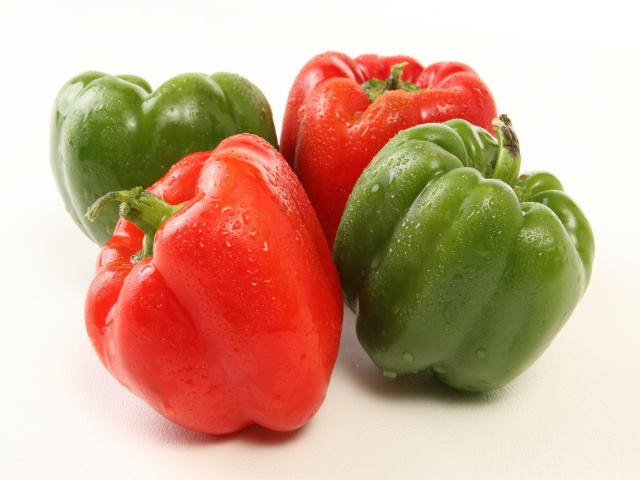

In [5]:
from IPython.display import display
from PIL import Image

image_folder = "./img"
listimage = [i for i in os.listdir(image_folder) if i.endswith("JPEG")]
path = os.path.join(image_folder, listimage[0])
img = cv2.imread(path)

display(Image.open(path))

We will also open and initialize the DPU device. We will create a DPU kernel and reuse it.
Throughout the entire notebook, we don't have to redo this step.

**Note**: if you open and close DPU multiple times, the Jupyter kernel might die;
this is because the current DNNDK implementation requires bitstream to be downloaded by XRT,
which is not supported by `pynq` package. Hence we encourage users to stay with
one single DPU session, both for program robustness and higher performance.

In [6]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)

### Single execution
We define a function that will use the DPU to make a prediction on an input 
image and provide a softmax output.

In [7]:
def predict_label(img):
    task = n2cube.dpuCreateTask(kernel, 0)

    dputils.dpuSetInputImage2(task, KERNEL_CONV_INPUT, img)
    n2cube.dpuGetInputTensor(task, KERNEL_CONV_INPUT)
    n2cube.dpuRunTask(task)
    size = n2cube.dpuGetOutputTensorSize(task, KERNEL_FC_OUTPUT)
    channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
    conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_FC_OUTPUT)
    outputScale = n2cube.dpuGetOutputTensorScale(task, KERNEL_FC_OUTPUT)
    softmax = n2cube.dpuRunSoftmax(conf, channel, size//channel, outputScale)

    n2cube.dpuDestroyTask(task)

    with open("img/words.txt", "r") as f:
        lines = f.readlines()
    return lines[np.argmax(softmax)]

In [8]:
label = predict_label(img)

print('Class label: {}'.format(label))

Class label: bell pepper



### Multiple executions
After we have verified the correctness of a single execution, we can
try multiple executions and measure the throughput in Frames Per Second (FPS).

Let's define a function that processes a single image in multiple iterations. 
The parameters are:
* `kernel`: DPU kernel.
* `img`: image to be classified.
* `count` : test rounds count.

The number of iterations is defined as `num_iterations` in previous cells.

In [9]:
def run_dpu_task(kernel, img, count):
    task = n2cube.dpuCreateTask(kernel, 0)

    count = 0
    while count < num_iterations:
        dputils.dpuSetInputImage2(task, KERNEL_CONV_INPUT, img)
        n2cube.dpuGetInputTensor(task, KERNEL_CONV_INPUT)
        n2cube.dpuRunTask(task)
        size = n2cube.dpuGetOutputTensorSize(task, KERNEL_FC_OUTPUT)
        channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
        conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_FC_OUTPUT)
        outputScale = n2cube.dpuGetOutputTensorScale(task, KERNEL_FC_OUTPUT)
        softmax = n2cube.dpuRunSoftmax(
            conf, channel, size//channel, outputScale)

        lock.acquire()
        count = count + threadnum
        lock.release()

    n2cube.dpuDestroyTask(task)

Now we are able to run the batch processing and print out DPU throughput.
Users can change the `image_folder` to point to other picture locations.
We will use the previously defined and classified image `img` and process it for
`num_interations` times.

In this example, we will just use a single thread.

The following cell may take a while to run. Please be patient.

In [10]:
threadAll = []
threadnum = 1

start = time.time()

for i in range(threadnum):
    t1 = threading.Thread(target=run_dpu_task, args=(kernel, img, i))
    threadAll.append(t1)
for x in threadAll:
    x.start()
for x in threadAll:
    x.join()

end = time.time()

fps = float(num_iterations/(end-start))
print("%.2f FPS" % fps)

88.15 FPS


### Clean up

Finally, when you are done with the DPU experiments, remember to destroy the kernel and close the DPU.

In [11]:
n2cube.dpuDestroyKernel(kernel)

0

Copyright (C) 2020 Xilinx, Inc